# Advance Laneline detection

In this project I will use advanced techniques to detect lanelines from images of road.

In [1]:
# Importing required libraries

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
print('Library import successful')

Library import successful


### 1. Calibrating Camera:

To detect lanelines currectly from image, I am calibrating camera to remove distortion from image. To calibrate camera, I am using chess board images from different angles and distances.

In [2]:
def calibrate_camera():
    
    # prepare object points
    nx = 9#TODO: enter the number of inside corners in x
    ny = 6#TODO: enter the number of inside corners in y

    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    objpoints = []
    imgpoints = []
    
    for fname in images:
            
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

def test_calibration(mtx, dist):
    fname = 'camera_cal/calibration1.jpg'
    img = cv2.imread(fname)

    un_dst = cv2.undistort(img, mtx, dist, None, mtx)

    fig = plt.figure()
    fig.suptitle('Undistortion matrix test')
    plt.imshow(un_dst)

### 2. Perspective Transform:

It is much easier to detect lanelines from top view to the road. To take advantage of this fact, I am transforming image to top view.

In [3]:
def perspective_transform():
    
    fname = 'test_images/straight_lines1.jpg'
    img = cv2.imread(fname)
    
    offset_x = 300 # offset for dst points
    offset_y = 50
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[580,460], [700, 460], [1040, 680], [260, 680]])
    #src = np.float32([[525,500], [760, 500], [1040, 680], [260, 680]])
    #src = np.float32([[580,410], [ 580, 890], [ 680, 1040], [ 680, 260]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[offset_x, offset_y], [img_size[0]-offset_x, offset_y], 
                                 [img_size[0]-offset_x, img_size[1]-offset_y], 
                                 [offset_x, img_size[1]-offset_y]])
    #dst = np.float32([[300,300], [1000,300], [1000,700], [300,700]])
    
    #print(dst)
    #print(dst1)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    
    
    return M, M_inv, img_size

print('functions defined')

functions defined


### 3. Sobel Operator

Once I have top view image, I am applying magnitude and direction sobel on it to generate binary image where only laneline appears white and most of the other pixels are blacked out.

In [4]:
def abs_sobel_threshold(img, sobel_kernel=3, thresh=(20, 100)):
    # Calculate directional gradient
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    return scaled_sobelx, scaled_sobely

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255), thresh=(20, 100)):
    sobelx, sobely = abs_sobel_threshold(img, sobel_kernel, thresh)
    
    mag_sobel = ((sobelx*sobelx)+(sobely*sobely))**(1/2)
    
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output, sobelx, sobely

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2), thresh=(20, 100)):
    
    sobelx, sobely = abs_sobel_threshold(img, sobel_kernel, thresh)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output, sobelx, sobely

def combined_sobel_threshold(img, sobel_kernel=15, thresh=(200, 255), mag_thresh=(150, 255), dir_thresh=(0, np.pi/2)):
    mag_binary, sobelx, sobely = mag_threshold(img, sobel_kernel, mag_thresh, thresh)
    dir_binary, sobelx, sobely = dir_threshold(img, sobel_kernel, dir_thresh, thresh)
    combined = np.zeros_like(sobelx)
    combined[((sobelx == 1) & (sobely == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

print('functions defined')

functions defined


### 4. HLS filtering:

As Sobel operator alone is not enough to detect lanelines in all conditions, I am using Hue and Saturation channels from HLS color space to detect lanelines and generate binary image with it.

In [5]:
def get_s_channel_binary(img, threshold=(90, 255)):
    s_channel = img[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel >= threshold[0]) & (s_channel <= threshold[1]))] = 1
    return s_binary

def get_h_channel_binary(img, threshold=(0, 60)):
    h_channel = img[:,:,0]
    h_binary = np.zeros_like(h_channel)
    h_binary[((h_channel >= threshold[0]) & (h_channel <= threshold[1]))] = 1
    return h_binary

def combined_color_threshold(img, s_threshold=(90, 255), h_threshold=(30, 70)):
    s_binary = get_s_channel_binary(img, s_threshold)
    h_binary = get_h_channel_binary(img, h_threshold)
    
    combined = np.zeros_like(s_binary)
    combined[(s_binary == 1) & (h_binary == 1)] = 1
    #combined[(s_binary == 1)] = 1
    return combined

### 5. Combining Sobel and HLS:

Now I have sobel binary image and binary image for H channel and S channel, I am combining all 3 binary channel with OR operator to not miss laneline.

In [6]:
def combined_sobel_color_threshold(img, displayImage):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if displayImage:
        fig = plt.figure()
        fig.suptitle('Gray scalled')
        plt.imshow( gray)
    
    combined_sobel = combined_sobel_threshold(gray)
    combined_sobel = np.uint8(combined_sobel)
    #print(combined_sobel.nonzero()[0].shape)
    #print(combined_sobel.max())
    #print(combined_sobel.dtype)
    
    if displayImage:
        fig = plt.figure()
        fig.suptitle('Combined Sobel magnitude and direction')
        plt.imshow(combined_sobel, cmap='gray')
    
    #combined_color = combined_color_threshold(img)
    #plt.imshow(combined_color, cmap='gray')
    #plt.figure()
    
    s_binary = get_s_channel_binary(img, threshold=(90, 255))
    h_binary = get_h_channel_binary(img, threshold=(30, 70))
    
    combined = np.zeros_like(combined_sobel)
    combined[((combined_sobel == 1) | (s_binary == 1)) | (h_binary == 1)] = 1
    return combined

### 6: Fit Polynomial on laneline:

As I have got lanelines, now I can find out a second degree polynomial to fit on lanelines. To do that I am performing following steps on combined binary image of Sobel and Color channel:

#### 6.1 Histogram:

I am computing histogram on columns of binary image to get base point of left and right lane. The base point of left lane will be where the highest peak in left half of histogram and same for base point of right lane in right half of histogram.

#### 6.2 Sliding window:

Now from base points of lanes I am applying sliding window to get whole lane points. Once I got all lane line points I used <code>numpy.polyfit</code> function to fit second order polynomial to those points.

In [7]:
def get_laneline_polynomials(binary_warped, displayImage):
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    if displayImage:
        fig = plt.figure()
        fig.suptitle('Histogram')
        plt.plot(histogram)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, left_fit, right_fit, ploty

In [8]:
def draw_lanelines(undist, warped, left_fitx, right_fitx, ploty, Minv, image):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

### 7. Radius of Curvature:

After fitting polynomial to laneline points here I am calculating radius of curvature of lane.

In [9]:
def measure_radius_of_curvature(ploty, left_fit, right_fit, left_fit_x, right_fit_x):
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/700 # meters per pixel in y dimension
    xm_per_pix = 3.7/650 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fit_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fit_x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return (left_curverad + right_curverad) / 2

### 8. Offset from Centre of lane:

After calculating radius of curvature, I calculate offset of car from centre of lane.

In [15]:
def find_lanelines(img, mtx, dist, M, M_inv, img_size, displayImage):
    un_dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    if displayImage:
        fig = plt.figure()
        fig.suptitle('Undistorted')
        plt.imshow(un_dst)
    
    warped = cv2.warpPerspective(un_dst, M, img_size)
    
    if displayImage:
        fig = plt.figure()
        fig.suptitle('Top View')
        plt.imshow(warped)
    
    combined = combined_sobel_color_threshold(warped, displayImage)
    
    if displayImage:
        fig = plt.figure()
        fig.suptitle('Binary image with combined Sobel and Color filters')
        plt.imshow( combined, cmap='gray')
    
    out_img, left_fitx, right_fitx, left_fit, right_fit, ploty = get_laneline_polynomials(combined, displayImage)
    
    if displayImage:
        fig = plt.figure()
        fig.suptitle('Binary image with polynomial fit')
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    result = draw_lanelines(un_dst, combined, left_fitx, right_fitx, ploty, M_inv, img)
    
    if displayImage:
        fig = plt.figure()
        fig.suptitle('Output image with detected lanelines in HLS color space')
        plt.imshow(result)
    
    centre_of_lane = abs(right_fitx[0] - left_fitx[0])
    
    curve_radius = measure_radius_of_curvature(ploty, left_fit, right_fit, left_fitx, right_fitx)
    offset_from_lane_centre = (abs(centre_of_lane - 640)/650) * 3.5
    
    cv2.putText(result,"radius: " + str(curve_radius) + 'm', ( 25, 100), cv2.FONT_HERSHEY_PLAIN, 3, (255, 255, 255), 4)
    cv2.putText(result,"Offset from lane centre: " + str(offset_from_lane_centre) + 'm', ( 25, 200), cv2.FONT_HERSHEY_PLAIN, 3, (255, 255, 255), 4)
    
    return result

In [11]:
def process_image(img):
    
    displayImage = False
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    result = find_lanelines(hls, mtx, dist, M, M_inv, img_size, displayImage)

    result_rgb = cv2.cvtColor(result, cv2.COLOR_HLS2RGB)
    
    return result_rgb

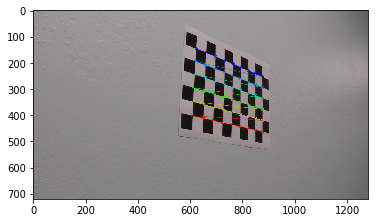

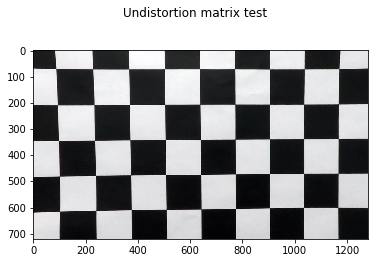

In [12]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

test_calibration(mtx, dist)

In [13]:
M, M_inv, img_size = perspective_transform()

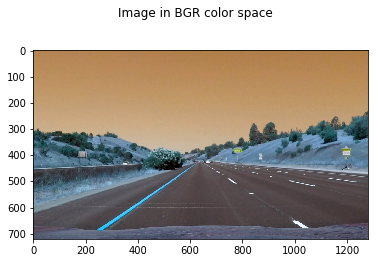

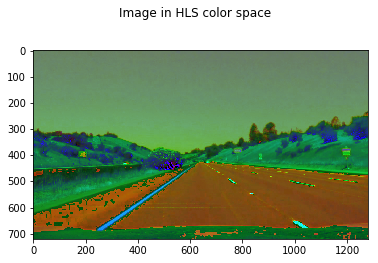

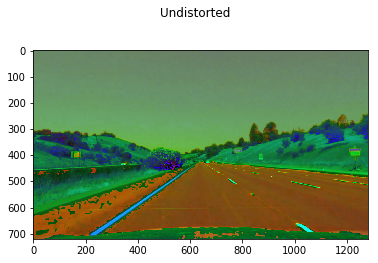

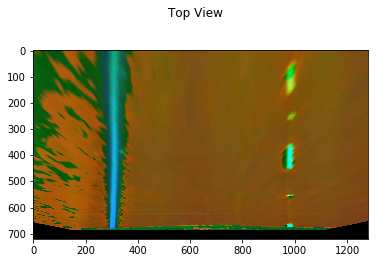

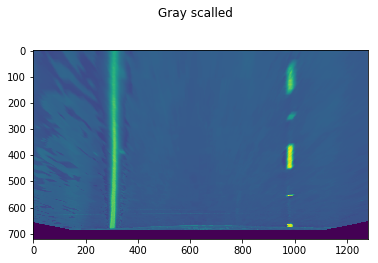

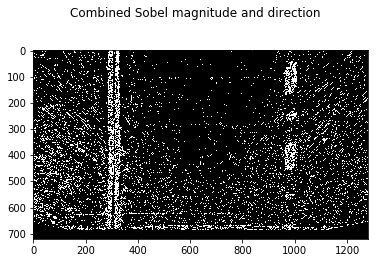

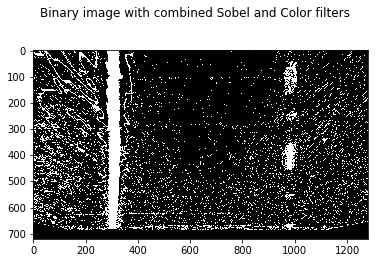

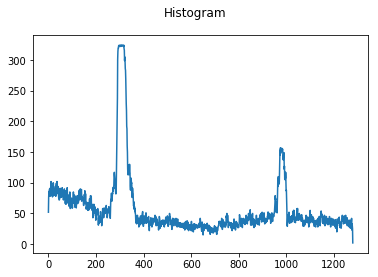

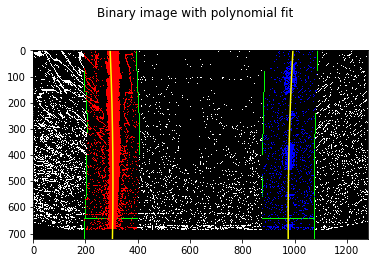

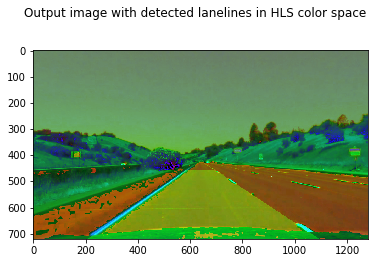

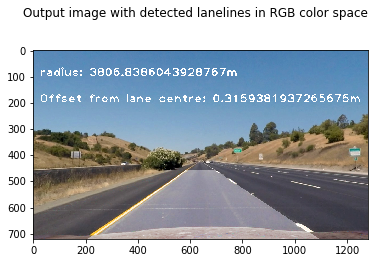

In [16]:
fname = 'test_images/straight_lines1.jpg'
#fname = 'test_images/test6.jpg'
#fname = 'custom_test_images/3.jpg'
img = cv2.imread(fname)

fig = plt.figure()
fig.suptitle('Image in BGR color space')
plt.imshow(img)

hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

fig = plt.figure()
fig.suptitle('Image in HLS color space')
plt.imshow(hls)

result = find_lanelines(hls, mtx, dist, M, M_inv, img_size, True)

result_rgb = cv2.cvtColor(result, cv2.COLOR_HLS2RGB)

fig = plt.figure()
fig.suptitle('Output image with detected lanelines in RGB color space')
plt.imshow(result_rgb)

In [17]:
white_output = './test_videos_output/project_video_output1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("./project_video.mp4").subclip(20,25)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video ./test_videos_output/project_video_output1.mp4
[MoviePy] Writing video ./test_videos_output/project_video_output1.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:46<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/project_video_output1.mp4 

Wall time: 6min 47s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### 8 Future Enhancements:

Right now there are some points where detected lane wobbles a bit. this can be improved by applying Sanity checks and improving thresholds of Sobel and Color filters.